In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load dataset
file_path = "/content/drive/MyDrive/Minor_project6thsem/Datasets/DDoS SDN Tree/DDoS-SDN-Tree star.xlsx"
df = pd.read_excel(file_path)

<ipython-input-7-b997d77631fc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette="coolwarm")


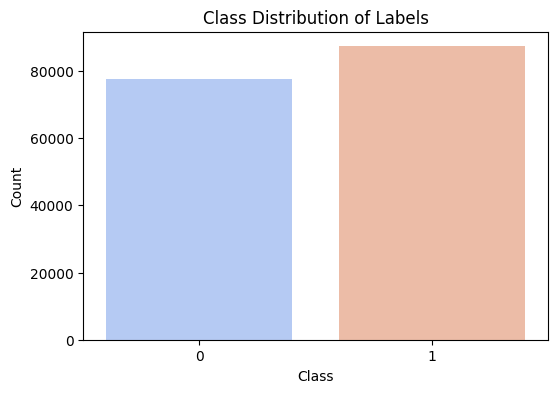

In [ ]:
# Visualize Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette="coolwarm")
plt.title("Class Distribution of Labels")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [3]:
# Convert numerical columns (fix European-style decimal issues)
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(str)
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass  # Ignore non-numeric columns

In [4]:
# Encode categorical variables
label_encoder = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = label_encoder.fit_transform(df[col])


In [5]:
# Define features and target
X = df.drop(columns=['label']).values
y = df['label'].values


In [6]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


In [8]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [9]:
# Create federated data split

def split_federated_data(X, y, num_clients=5):
    split_size = len(X) // num_clients
    client_datasets = []
    for i in range(num_clients):
        start = i * split_size
        end = (i + 1) * split_size if i != num_clients - 1 else len(X)
        dataset = TensorDataset(X[start:end], y[start:end])
        client_datasets.append(DataLoader(dataset, batch_size=64, shuffle=True))
    return client_datasets

client_loaders = split_federated_data(X_train_tensor, y_train_tensor, num_clients=5)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

In [10]:
# Define an enhanced neural network

class ImprovedFedNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedFedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [11]:
# Initialize global model
global_model = ImprovedFedNN(input_size=X_train.shape[1])


In [12]:
# Federated averaging function
def federated_averaging(global_model, client_models):
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([client_models[i].state_dict()[key] for i in range(len(client_models))], dim=0).mean(dim=0)
    global_model.load_state_dict(global_state_dict)

In [13]:
# Training federated clients
def train_federated(global_model, client_loaders, epochs=20):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        client_models = []
        for client_loader in client_loaders:
            model = ImprovedFedNN(input_size=X_train.shape[1])
            model.load_state_dict(global_model.state_dict())
            optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
            model.train()
            for X_batch, y_batch in client_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            client_models.append(model)
        federated_averaging(global_model, client_models)
        print(f"Epoch {epoch+1}/{epochs} completed.")


In [14]:
# Train federated model
train_federated(global_model, client_loaders, epochs=20)

Epoch 1/20 completed.
Epoch 2/20 completed.
Epoch 3/20 completed.
Epoch 4/20 completed.
Epoch 5/20 completed.
Epoch 6/20 completed.
Epoch 7/20 completed.
Epoch 8/20 completed.
Epoch 9/20 completed.
Epoch 10/20 completed.
Epoch 11/20 completed.
Epoch 12/20 completed.
Epoch 13/20 completed.
Epoch 14/20 completed.
Epoch 15/20 completed.
Epoch 16/20 completed.
Epoch 17/20 completed.
Epoch 18/20 completed.
Epoch 19/20 completed.
Epoch 20/20 completed.


In [15]:
# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(predicted.numpy())
    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred))
    return y_true, y_pred

In [16]:
# Run evaluation
y_true, y_pred = evaluate_model(global_model, test_loader)

Test Accuracy: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23286
           1       1.00      1.00      1.00     26184

    accuracy                           1.00     49470
   macro avg       1.00      1.00      1.00     49470
weighted avg       1.00      1.00      1.00     49470



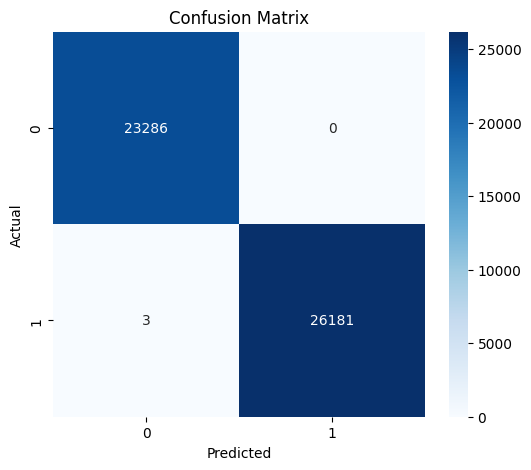

In [17]:
# Confusion matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [21]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Get probability for class 1
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(predicted.numpy())
            y_probs.extend(probs.numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred))
    return y_true, y_pred, y_probs  # Ensure probabilities are returned


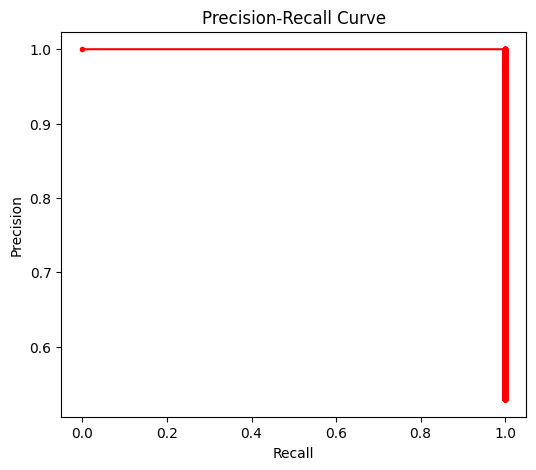

In [23]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(y_true, y_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, marker='.', color='red')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Call after evaluation
plot_precision_recall(y_true, y_probs)


Test Accuracy: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23286
           1       1.00      1.00      1.00     26184

    accuracy                           1.00     49470
   macro avg       1.00      1.00      1.00     49470
weighted avg       1.00      1.00      1.00     49470



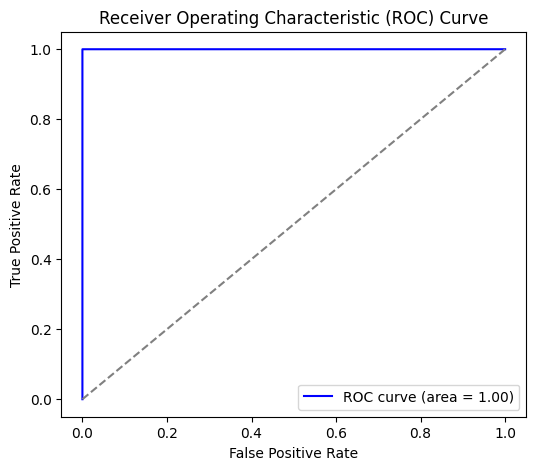

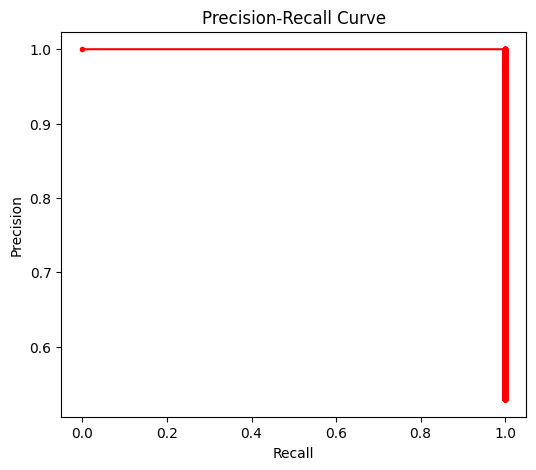

In [24]:
y_true, y_pred, y_probs = evaluate_model(global_model, test_loader)

# Now, `y_probs` is available for plotting
plot_roc_curve(y_true, y_probs)
plot_precision_recall(y_true, y_probs)


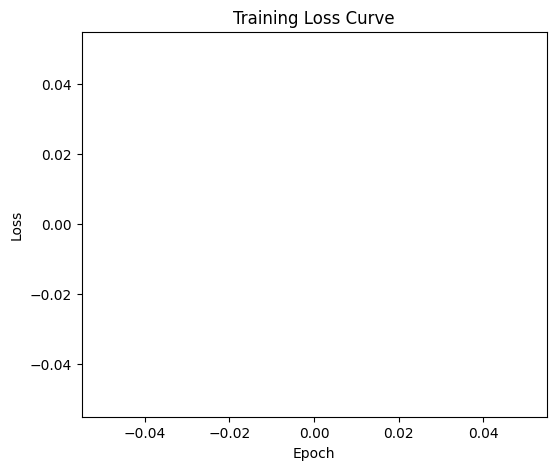

In [25]:
train_losses = []

def train_federated(global_model, client_loaders, epochs=20):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        client_models = []
        epoch_loss = 0
        for client_loader in client_loaders:
            model = ImprovedFedNN(input_size=X_train.shape[1])
            model.load_state_dict(global_model.state_dict())
            optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
            model.train()
            for X_batch, y_batch in client_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            client_models.append(model)

        federated_averaging(global_model, client_models)
        train_losses.append(epoch_loss / len(client_loaders))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(client_loaders):.4f}")

# Plot loss curve
def plot_loss_curve(train_losses):
    plt.figure(figsize=(6, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

# Call after training
plot_loss_curve(train_losses)


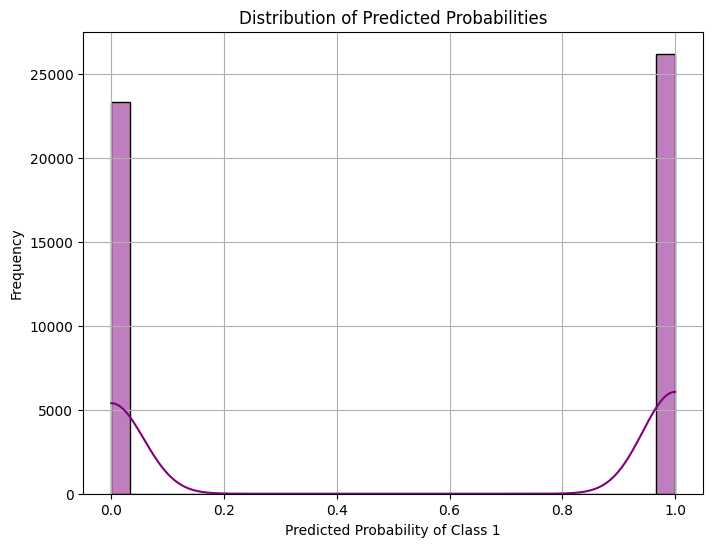

In [26]:

# Distribution of Predicted Probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_probs, bins=30, kde=True, color="purple")
plt.xlabel("Predicted Probability of Class 1")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.grid()
plt.show()
